<a href="https://colab.research.google.com/github/casllmproject/wjs_llm_project/blob/main/DE_human_ai_alignments2024Dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount goolge drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load human responses
human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_de.csv')

# Replace 777 and 999 with NaN
human_df.replace({777: pd.NA, 999: pd.NA}, inplace=True)

# Save the updated dataset
human_df.to_csv('/content/drive/MyDrive/AI_shoes/wjs_de_cleaned.csv', index=False)

print("Replaced 777 and 999 with NA and saved the cleaned dataset.")


Replaced 777 and 999 with NA and saved the cleaned dataset.


In [ ]:
# Load the cleaned human responses
human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_de_cleaned.csv')

In [ ]:
# Assuming 'column_name' is the column causing the issue
human_df['pol_view'] = pd.to_numeric(human_df['pol_view'], errors='coerce')
human_df['gender'] = pd.to_numeric(human_df['gender'], errors='coerce')
human_df['empl'] = pd.to_numeric(human_df['empl'], errors='coerce')
human_df['mbackg'] = pd.to_numeric(human_df['mbackg'], errors='coerce')
human_df['gen_edu'] = pd.to_numeric(human_df['gen_edu'], errors='coerce')

In [ ]:
# Apply across all variables to make 777, and 999 as missing
human_df = human_df.applymap(lambda x: np.nan if x in [777, 999] else x)

# For 'gender': Keep only 1 and 2, others as missing
human_df['gender'] = human_df['gender'].apply(lambda x: x if x in [1, 2] else np.nan)

# For 'empl': Combine 1 and 3 as 1, 2 and 4 as 2, 5 stays as 5, others as missing
human_df['empl'] = human_df['empl'].apply(lambda x: 1 if x in [1, 3] else (2 if x in [2, 4] else (5 if x == 5 else np.nan)))

# For 'mbackg': Make 7, 8, and 9 as missing
human_df['mbackg'] = human_df['mbackg'].apply(lambda x: x if x not in [7, 8, 9] else np.nan)

# For 'gen_edu': Make 1, 2, 5 as missing
human_df['gen_edu'] = human_df['gen_edu'].apply(lambda x: x if x not in [1] else np.nan)

# Display the updated DataFrame
print(human_df)

      COUNTRY STATUS           job_ttle  empl empl6  incm_j empl_c1 empl_c2  \
0          28                Freelancer   5.0         100.0                   
1          28                Freelancer   5.0          90.0                   
2          28                Freelancer   5.0         100.0                   
3          28             Senior editor   1.0         100.0                   
4          28                Freelancer   5.0          80.0                   
...       ...    ...                ...   ...   ...     ...     ...     ...   
1216       28             Senior editor   1.0         100.0                   
1217       28         Student Assistant   2.0          69.0                   
1218       28                   Trainee   1.0         100.0                   
1219       28         Student Assistant   2.0          75.0                   
1220       28             Senior editor   5.0         100.0                   

     incm_o_A incm_o_B  ... WB_GDPC_GROW WP_GNI_GRO

<ipython-input-44-bc7563152c79>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  human_df = human_df.applymap(lambda x: np.nan if x in [777, 999] else x)


In [ ]:
# Function to compute distribution of human responses by group
def compute_distribution(df, variable_name, group):
    distribution = df.groupby(group)[variable_name].value_counts(normalize=True).unstack().fillna(0)
    return distribution

# Create political ideological groups
def categorize_political_view(df):
    conditions = [
        (df['pol_view'] <= 4),
        (df['pol_view'] == 5),
        (df['pol_view'] >= 6)
    ]
    choices = ['left', 'center', 'right']
    df['pol_view_group'] = np.select(conditions, choices, default=pd.NA)
    return df

# Employment status consolidation
def consolidate_employment_status(df):
    consolidated_empl_mapping = {
        1: 1,  # Full-time
        2: 2,  # Part-time

    }
    df['empl'] = df['empl'].replace(consolidated_empl_mapping)
    return df

# Apply all categorizations to the DataFrame
def preprocess_human_df(df):
    df = categorize_political_view(df)
    df = consolidate_employment_status(df)
    return df

# Label mappings
gender_labels = {1: 'Female', 2: 'Male'}
empl_labels = {1: 'Full-time', 2: 'Part-time', 5: 'Freelance or self-employed'}
mbackg_labels = {
    1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio', 5: 'News agency',
    6: 'Internet native'
}
gen_edu_labels = {
    2: 'Completed high school',
    3: 'Bachelor’s degree or equivalent',
    4: 'Master\'s degree or equivalent',
    5: 'Doctorate',
    6: 'Undertook some university studies, but no degree'
}

# Function to map labels
def map_labels(distribution, labels):
    return distribution.rename(index=labels)

# Function to calculate and print distribution for different grouping variables
def compute_and_print_distributions(df, variable_name):
    # Political view group distribution
    political_distribution = compute_distribution(df, variable_name, 'pol_view_group')
    print(f"Distribution by political view group on {variable_name}:")
    print(political_distribution)

    # Gender distribution
    gender_distribution = compute_distribution(df, variable_name, 'gender')
    gender_distribution = map_labels(gender_distribution, gender_labels)
    print(f"\nDistribution by gender on {variable_name}:")
    print(gender_distribution)

    # Employment status distribution
    employment_distribution = compute_distribution(df, variable_name, 'empl')
    employment_distribution = map_labels(employment_distribution, empl_labels)
    print(f"\nDistribution by employment status on {variable_name}:")
    print(employment_distribution)

    # Media background distribution
    media_background_distribution = compute_distribution(df, variable_name, 'mbackg')
    media_background_distribution = map_labels(media_background_distribution, mbackg_labels)
    print(f"\nDistribution by media background on {variable_name}:")
    print(media_background_distribution)

    # General education distribution
    education_distribution = compute_distribution(df, variable_name, 'gen_edu')
    education_distribution = map_labels(education_distribution, gen_edu_labels)
    print(f"\nDistribution by general education on {variable_name}:")
    print(education_distribution)

# Example usage
human_df = preprocess_human_df(human_df)  # Apply preprocessing
compute_and_print_distributions(human_df, 'role_A')  # Calculate and print distributions for 'role_A'


Distribution by political view group on role_A:
role_A               1.0       2.0       3.0       4.0       5.0
pol_view_group                                                  
center          0.018634  0.031056  0.146998  0.455487  0.347826
left            0.015707  0.040140  0.136126  0.347295  0.460733
right           0.031915  0.021277  0.074468  0.329787  0.542553

Distribution by gender on role_A:
role_A       1.0       2.0       3.0       4.0       5.0
gender                                                  
Female  0.011673  0.040856  0.173152  0.381323  0.392996
Male    0.021505  0.029186  0.109063  0.390169  0.450077

Distribution by employment status on role_A:
role_A                           1.0       2.0       3.0       4.0       5.0
empl                                                                        
Full-time                   0.014640  0.029279  0.132883  0.387387  0.435811
Part-time                   0.011494  0.045977  0.091954  0.505747  0.344828
Freelance 

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    distances = {}
    for group in human_distribution.index:  # Loop through groups like 'left', 'Female', etc.
        options = human_distribution.columns.astype(int)
        human_probs = human_distribution.loc[group].values
        gpt_value = int(gpt_response)

        # Convert gpt_value to a list and ensure it is in the same range as options
        gpt_probs = np.zeros_like(human_probs)
        if gpt_value in options:
            gpt_probs[options.get_loc(gpt_value)] = 1

        # Compute Wasserstein distance
        distance = wasserstein_distance(gpt_probs, human_probs)
        distances[group] = distance
    return distances

# Function to compute and display Wasserstein distances for each group
def compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name):
    human_distribution = compute_distribution(df, variable_name, group_col)
    distances = compute_wasserstein_distance(human_distribution, gpt_response)

    print(f'\nWasserstein Distances between {gpt_model} and {group_name} distributions for "{variable_name}":')
    for group, distance in distances.items():
        label = group_labels.get(group, group)
        print(f"{label}: {distance}")

# Define updated labels for each grouping variable
pol_view_labels = {'left': 'Left', 'center': 'Center', 'right': 'Right'}
gender_labels = {1: 'Female', 2: 'Male'}
empl_labels = {1: 'Full-time', 2: 'Part-time', 5: 'Freelance or self-employed'}
mbackg_labels = {
    1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio', 5: 'News agency',
    6: 'Internet native'
}
gen_edu_labels = {
    2: 'Completed high school',
    3: 'Bachelor’s degree or equivalent',
    4: 'Master\'s degree or equivalent',
    5: 'Doctorate',
    6: 'Undertook some university studies, but no degree'
}

# Example: Compute Wasserstein distance for GPT-4o's response for 'role_A'
gpt_model = 'gpt-4o-2024-08-06'
gpt_responses_df = pd.read_csv(f'/content/drive/MyDrive/AI_shoes/gpt-4o-2024-08-06_responses.csv')

# Find the response for 'role_A' in the GPT responses CSV
gpt_response = gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == 'role_A', 'Response'].values[0]

# Apply political view group categorization
human_df = categorize_political_view(human_df)

# Consolidate employment statuses
human_df = consolidate_employment_status(human_df)

# Calculate and display Wasserstein distances for each grouping variable
compute_and_display_distances(human_df, 'role_A', gpt_response, 'pol_view_group', pol_view_labels, 'political view')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'gender', gender_labels, 'gender')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'empl', empl_labels, 'employment status')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'mbackg', mbackg_labels, 'media background')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'gen_edu', gen_edu_labels, 'general education')


Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "role_A":
Center: 0.21780538302277433
Left: 0.21570680628272249
Right: 0.1829787234042553

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "role_A":
Female: 0.24280155642023346
Male: 0.21996927803379418

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "role_A":
Full-time: 0.22567567567567567
Part-time: 0.19770114942528733
Freelance or self-employed: 0.23765690376569037

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "role_A":
Newspaper: 0.21524249422632796
Magazine: 0.21399176954732507
TV: 0.19317073170731708
Radio: 0.2019607843137255
News agency: 0.17142857142857143
Internet native: 0.2333333333333333

Wasserstein Distances between gpt-4o-2024-08-06 and general education distributions for "role_A":
Completed high school: 0.22352941176470587
Bachelor’s degree or equivalent: 0.22585034013605443


In [ ]:
# Function to calculate overall Mean and Standard Deviation
def calculate_overall_mean_and_sd(all_distances):
    overall_distances = [distance for group_distances in all_distances.values() for distance in group_distances.values()]
    mean_distance = np.mean(overall_distances)
    sd_distance = np.std(overall_distances)
    return mean_distance, sd_distance

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    distances = {}
    for group in human_distribution.index:  # Loop through groups like 'left', 'Female', etc.
        options = human_distribution.columns.astype(int)
        human_probs = human_distribution.loc[group].values
        gpt_value = int(gpt_response)

        # Convert gpt_value to a list and ensure it is in the same range as options
        gpt_probs = np.zeros_like(human_probs)
        if gpt_value in options:
            gpt_probs[options.get_loc(gpt_value)] = 1

        # Compute Wasserstein distance
        distance = wasserstein_distance(gpt_probs, human_probs)
        distances[group] = distance
    return distances

# Function to compute and display Wasserstein distances and overall statistics
def compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name):
    human_distribution = compute_distribution(df, variable_name, group_col)
    distances = compute_wasserstein_distance(human_distribution, gpt_response)

    # Display distances for each group
    print(f'\nWasserstein Distances between {gpt_model} and {group_name} distributions for "{variable_name}":')
    for group, distance in distances.items():
        label = group_labels.get(group, group)
        print(f"{label}: {distance}")

    # Return the group-wise distances for aggregation later
    return distances

# Aggregate all Wasserstein distances for overall statistics
def aggregate_and_display_overall_statistics(all_distances):
    # Compute overall Mean and SD across all grouping variables
    mean_distance, sd_distance = calculate_overall_mean_and_sd(all_distances)

    print("\nOverall Statistics across all grouping variables:")
    print(f"Mean (M): {mean_distance:.4f}")
    print(f"Standard Deviation (SD): {sd_distance:.4f}")

# Main execution with overall statistics computation
gpt_model = 'gpt-4o-2024-08-06'
gpt_responses_df = pd.read_csv(f'/content/drive/MyDrive/AI_shoes/gpt-4o-2024-08-06_responses.csv')

# Find the response for 'role_A' in the GPT responses CSV
gpt_response = gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == 'role_A', 'Response'].values[0]

# Apply political view group categorization
human_df = categorize_political_view(human_df)

# Consolidate employment statuses
human_df = consolidate_employment_status(human_df)

# Compute and collect Wasserstein distances for all grouping variables
all_distances = {}
all_distances['political view'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'pol_view_group', pol_view_labels, 'political view')
all_distances['gender'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'gender', gender_labels, 'gender')
all_distances['employment status'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'empl', empl_labels, 'employment status')
all_distances['media background'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'mbackg', mbackg_labels, 'media background')
all_distances['general education'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'gen_edu', gen_edu_labels, 'general education')

# Compute and display overall statistics across all groups
aggregate_and_display_overall_statistics(all_distances)


Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "role_A":
Center: 0.21780538302277433
Left: 0.21570680628272249
Right: 0.1829787234042553

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "role_A":
Female: 0.24280155642023346
Male: 0.21996927803379418

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "role_A":
Full-time: 0.22567567567567567
Part-time: 0.19770114942528733
Freelance or self-employed: 0.23765690376569037

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "role_A":
Newspaper: 0.21524249422632796
Magazine: 0.21399176954732507
TV: 0.19317073170731708
Radio: 0.2019607843137255
News agency: 0.17142857142857143
Internet native: 0.2333333333333333

Wasserstein Distances between gpt-4o-2024-08-06 and general education distributions for "role_A":
Completed high school: 0.22352941176470587
Bachelor’s degree or equivalent: 0.22585034013605443


In [ ]:
# Function to compute Wasserstein distances for all variables
def compute_wasserstein_for_variables(df, variables, gpt_responses, groupings):
    overall_results = {}  # To store results for all variables

    for variable_name in variables:
        print(f"\nProcessing variable: {variable_name}")
        gpt_response = gpt_responses.get(variable_name)
        if gpt_response is None:
            print(f"Warning: GPT response for '{variable_name}' not found.")
            continue

        variable_results = {}

        # Compute distances for each grouping
        for group_col, (group_labels, group_name) in groupings.items():
            print(f" - Grouping: {group_name}")
            distances = compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name)
            variable_results[group_name] = distances

        # Store results for the variable
        overall_results[variable_name] = variable_results

    return overall_results

# Function to compute overall mean and SD for all variables
def compute_overall_metrics(all_results):
    summary_metrics = {}

    for variable_name, group_results in all_results.items():
        all_distances = [
            distance for group_distances in group_results.values()
            for distance in group_distances.values()
        ]
        mean_distance = np.mean(all_distances)
        sd_distance = np.std(all_distances)
        summary_metrics[variable_name] = {"Mean (M)": mean_distance, "SD": sd_distance}

    return summary_metrics

In [ ]:
# Define groupings
groupings = {
    "pol_view_group": (pol_view_labels, "political view"),
    "gender": (gender_labels, "gender"),
    "empl": (empl_labels, "employment status"),
    "mbackg": (mbackg_labels, "media background"),
    "gen_edu": (gen_edu_labels, "general education"),
}

In [ ]:
for col in human_df.columns:
    human_df[col] = pd.to_numeric(human_df[col], errors='coerce')  # Convert non-numeric to NaN
human_df.fillna(0, inplace=True)  # Replace NaN with 0

In [ ]:
# Load GPT responses and variables
gpt_responses_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/gpt-4o-2024-08-06_responses.csv')
gpt_responses = dict(zip(gpt_responses_df['Variable_Name'], gpt_responses_df['Response']))

# Define the list of variables to process
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D",
             "epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C","epist2_D", "epist2_E", "epist2_F",
             "role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]  # Replace with your full variable list

# Apply any necessary preprocessing to human_df
human_df = categorize_political_view(human_df)
human_df = consolidate_employment_status(human_df)

# Compute Wasserstein distances for all variables
all_results = compute_wasserstein_for_variables(human_df, variables, gpt_responses, groupings)

# Compute overall metrics (Mean and SD) for all variables
summary_metrics = compute_overall_metrics(all_results)

# Display summary metrics
print("\nSummary of Mean (M), SD, and CV for all variables:")
for variable, metrics in summary_metrics.items():
    mean = metrics['Mean (M)']
    sd = metrics['SD']
    cv = sd / mean if mean != 0 else 0  # Avoid division by zero
    print(f"{variable}: M = {mean:.4f}, SD = {sd:.4f}, CV = {cv:.4f}")


Processing variable: ethic1_A
 - Grouping: political view

Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "ethic1_A":
Center: 0.10766045548654246
Left: 0.19616977225672877
Right: 0.14893617021276595
 - Grouping: gender

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "ethic1_A":
0.0: 0.17575757575757578
Female: 0.1553398058252427
Male: 0.1515616999487967
 - Grouping: employment status

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "ethic1_A":
0.0: 0.16666666666666663
Full-time: 0.14602102102102102
Part-time: 0.20075757575757575
Freelance or self-employed: 0.18410041841004182
 - Grouping: media background

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "ethic1_A":
0.0: 0.1695906432748538
Newspaper: 0.16166281755196305
Magazine: 0.11934156378600824
TV: 0.1463414634146341
Radio: 0.17320261437908496
News agency: 0.15873015873015872
Internet n

In [ ]:
# Define grouping variables as a global constant
GROUPING_VARIABLES = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time',
        2: 'Part-time',
        5: 'Freelance'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native'
    },
    'gen_edu': {
        2: 'High School',
        3: 'BA degree',
        4: 'MA degree',
        5: 'Doctorate',
        6: 'No formal degree'
    }
}

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate an integrated heatmap for all variables and grouping categories
def generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    # Initialize an empty DataFrame to store the results
    heatmap_data = pd.DataFrame(columns=variables)

    # Compute Wasserstein distances for each group and variable
    for group_col, group_labels in grouping_variables.items():
        for group, label in group_labels.items():
            row = {}
            for var in variables:
                gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
                human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

                # Check if the distribution is empty and skip if it is
                if not human_distribution.empty:
                    distance = compute_wasserstein_distance(human_distribution, gpt_response)
                    row[var] = distance
                else:
                    row[var] = np.nan

            # Add the row for this group
            heatmap_data.loc[label] = row

    # Create a heatmap with raw scores
    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_data.astype(float), cmap='Blues_r', annot=True, fmt=".3f", vmin=0, vmax=1, cbar_kws={'label': 'Wasserstein Distance'})
    plt.title('Wasserstein Distances Across Variables and Grouping Categories', fontsize=12)  # Smaller title size
    plt.xlabel('Variables')
    plt.ylabel('Grouping Categories')
    plt.show()

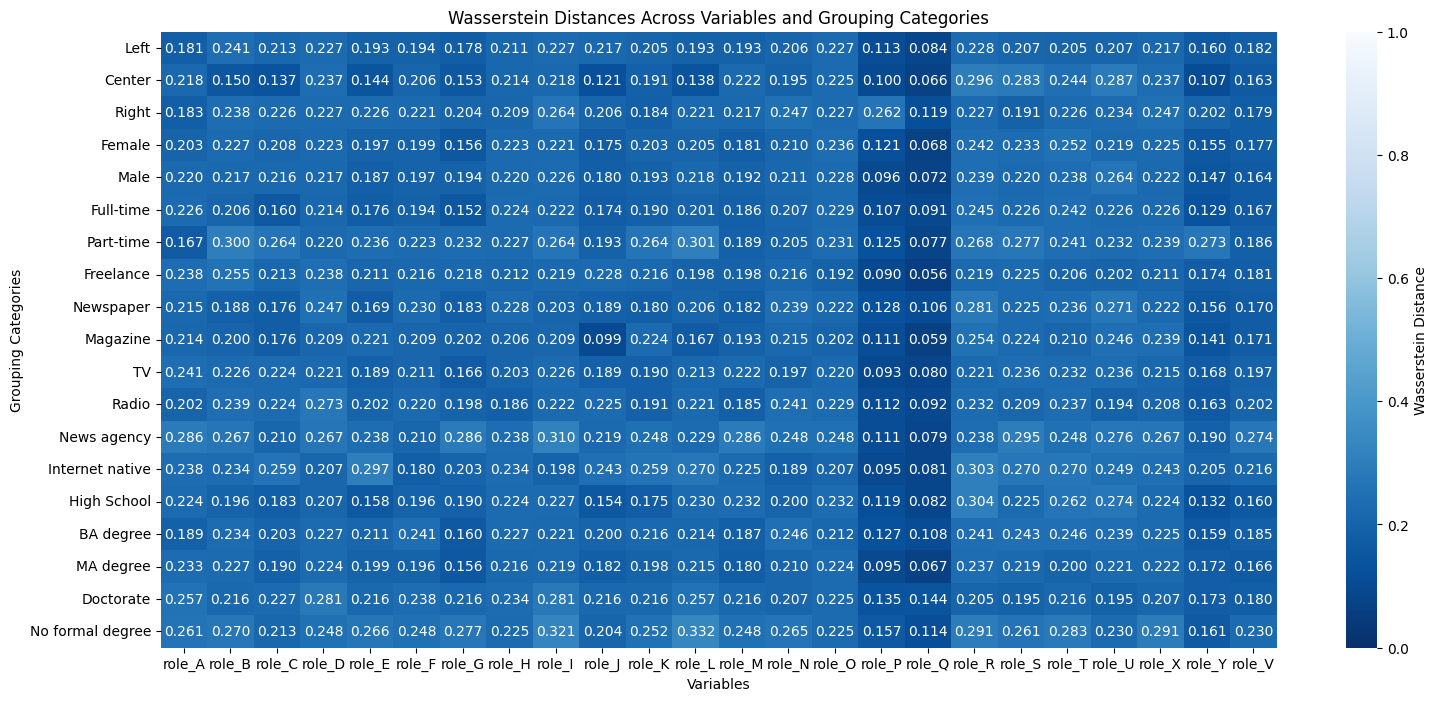

In [ ]:
# role
variables = ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]

# Generate an integrated heatmap for all variables and grouping categories
generate_integrated_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)


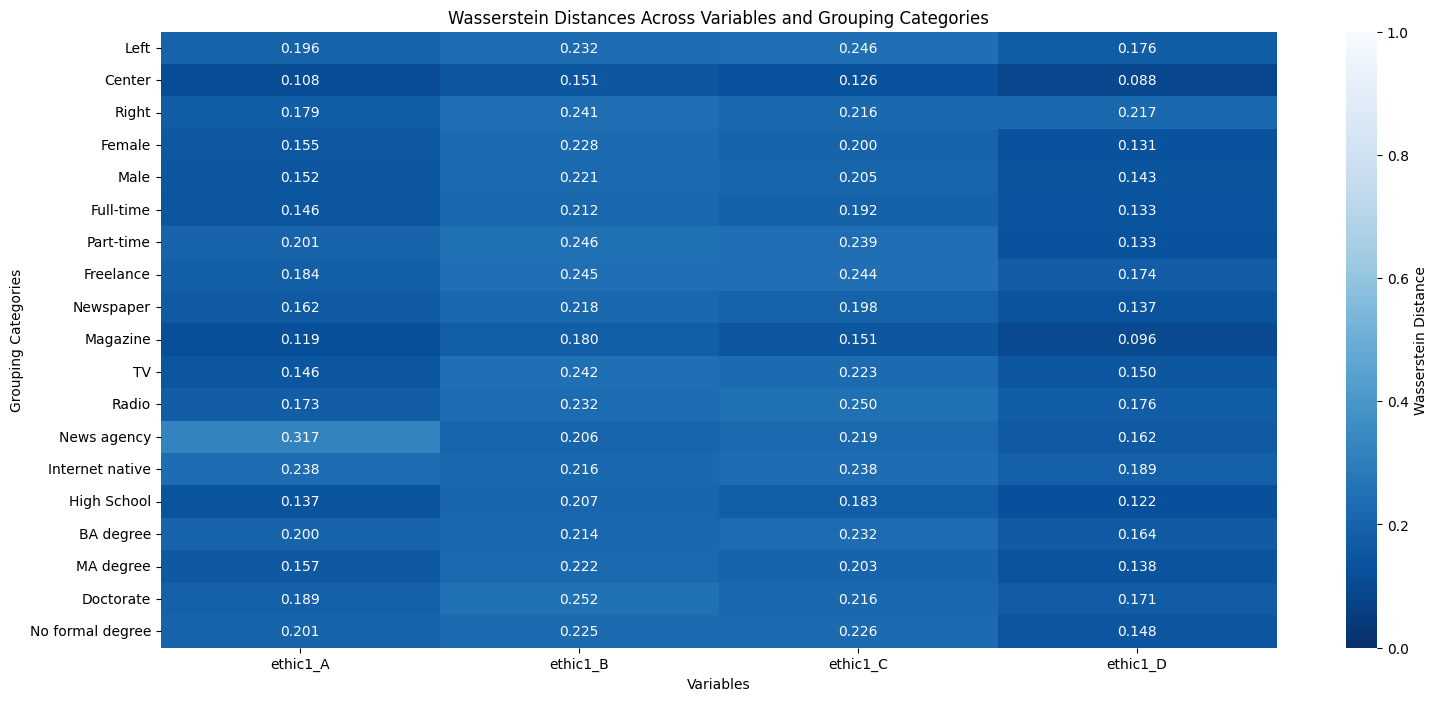

In [ ]:
# ethics
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]

# Generate an integrated heatmap for all variables and grouping categories
generate_integrated_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)

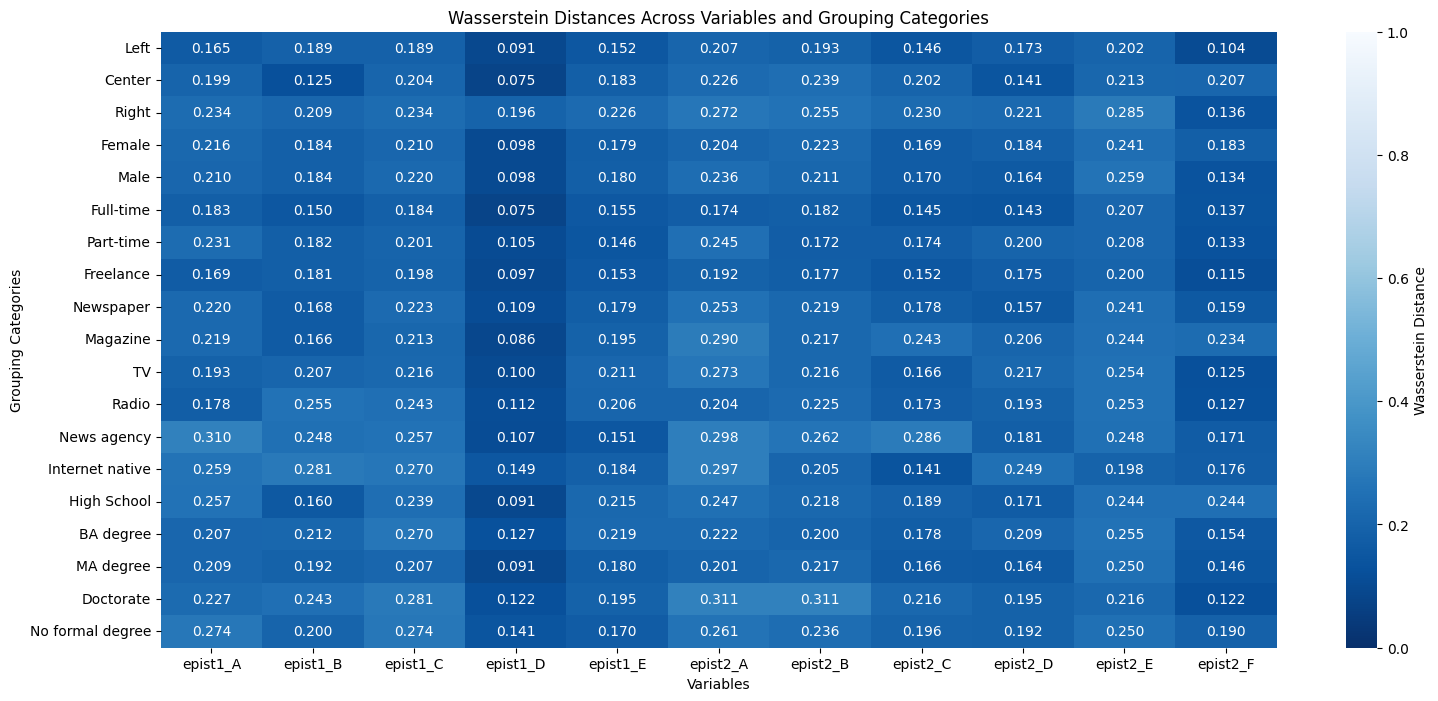

In [ ]:
# epist
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C","epist2_D", "epist2_E", "epist2_F"]

# Generate an integrated heatmap for all variables and grouping categories
generate_integrated_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'pol_view_group': 'red',
    'gender': 'blue',
    'empl': 'green',
    'mbackg': 'purple',
    'gen_edu': 'orange'
}
# Custom labels for legend
legend_labels = {
    'pol_view_group': 'Political Groups',
    'gender': 'Gender',
    'empl': 'Employment Status',
    'mbackg': 'Background',
    'gen_edu': 'General Education'
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables, plot_title):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    plt.figure(figsize=(12, 8))

    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=1.0)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        # Use the custom legend labels
        scatter = plt.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=legend_labels.get(group_col, group_col),  # Use custom label here
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        plt.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        plt.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(0.65, 0.90)
    plt.xlabel('Profile Group')
    plt.ylabel('Representativeness')
    plt.title(plot_title)  # Use the manually provided title
    plt.xticks(rotation=60)
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.show()

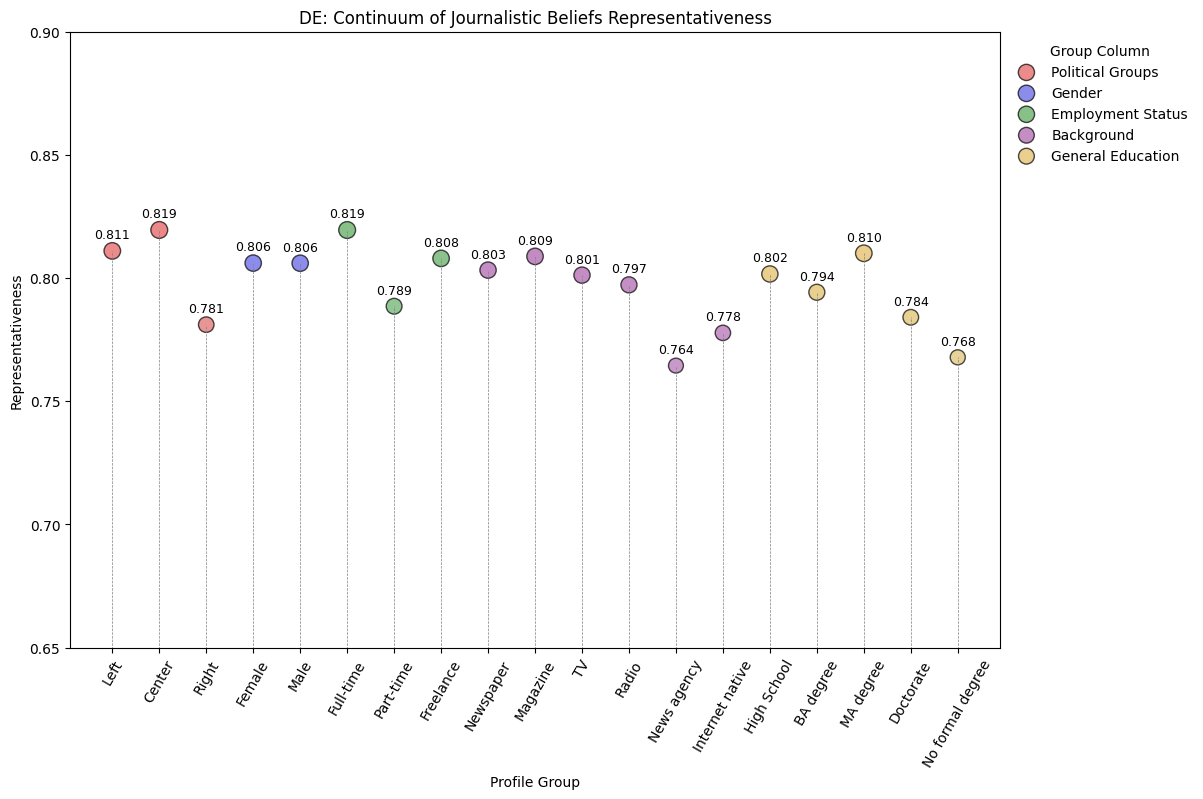

In [ ]:
#Total
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D",
             "epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C","epist2_D", "epist2_E", "epist2_F",
             "role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]
manual_title = "DE: Continuum of Journalistic Beliefs Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

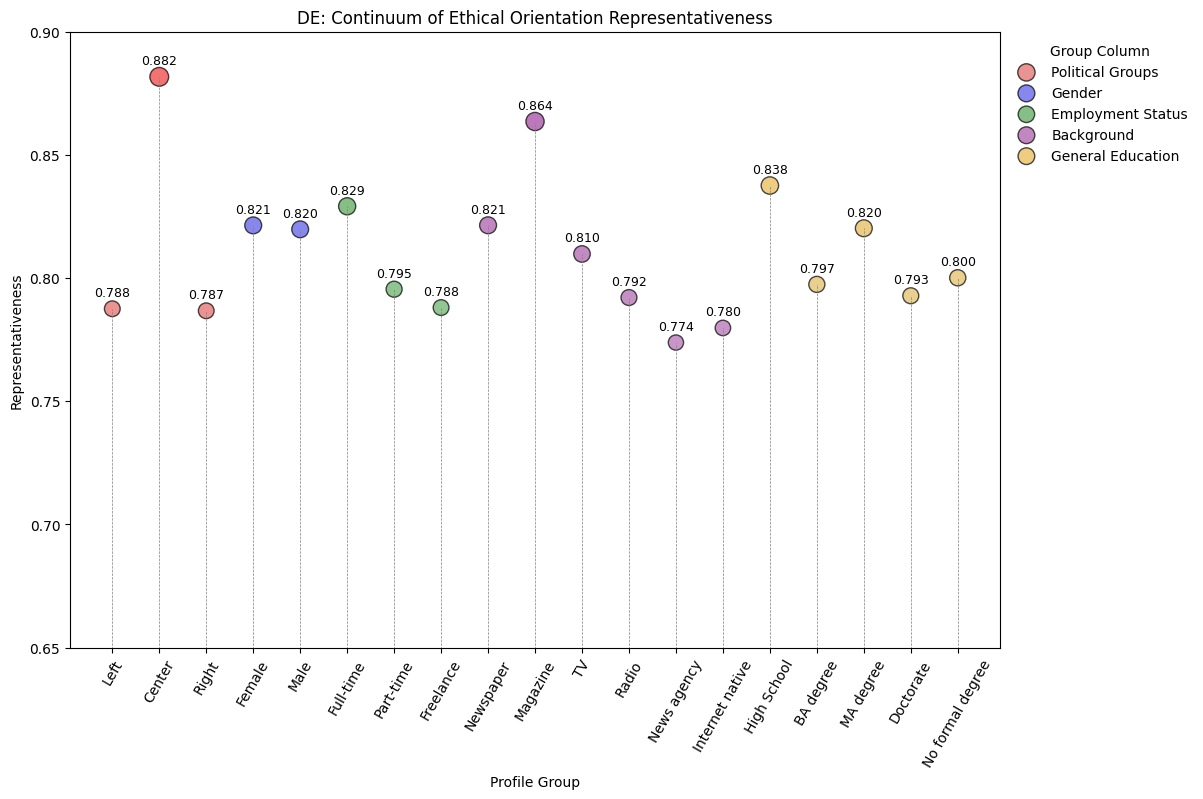

In [ ]:
#ethic
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]
manual_title = "DE: Continuum of Ethical Orientation Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

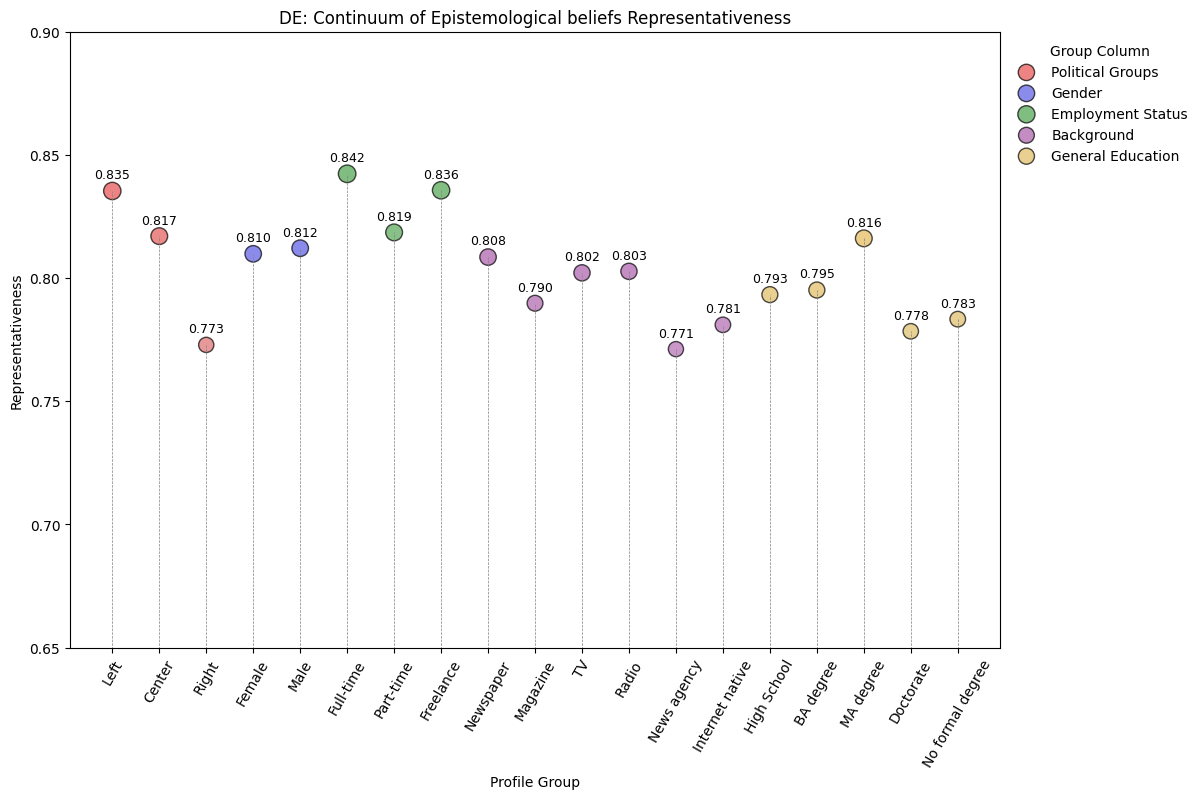

In [ ]:
#Epist
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C","epist2_D", "epist2_E", "epist2_F"]
manual_title = "DE: Continuum of Epistemological beliefs Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

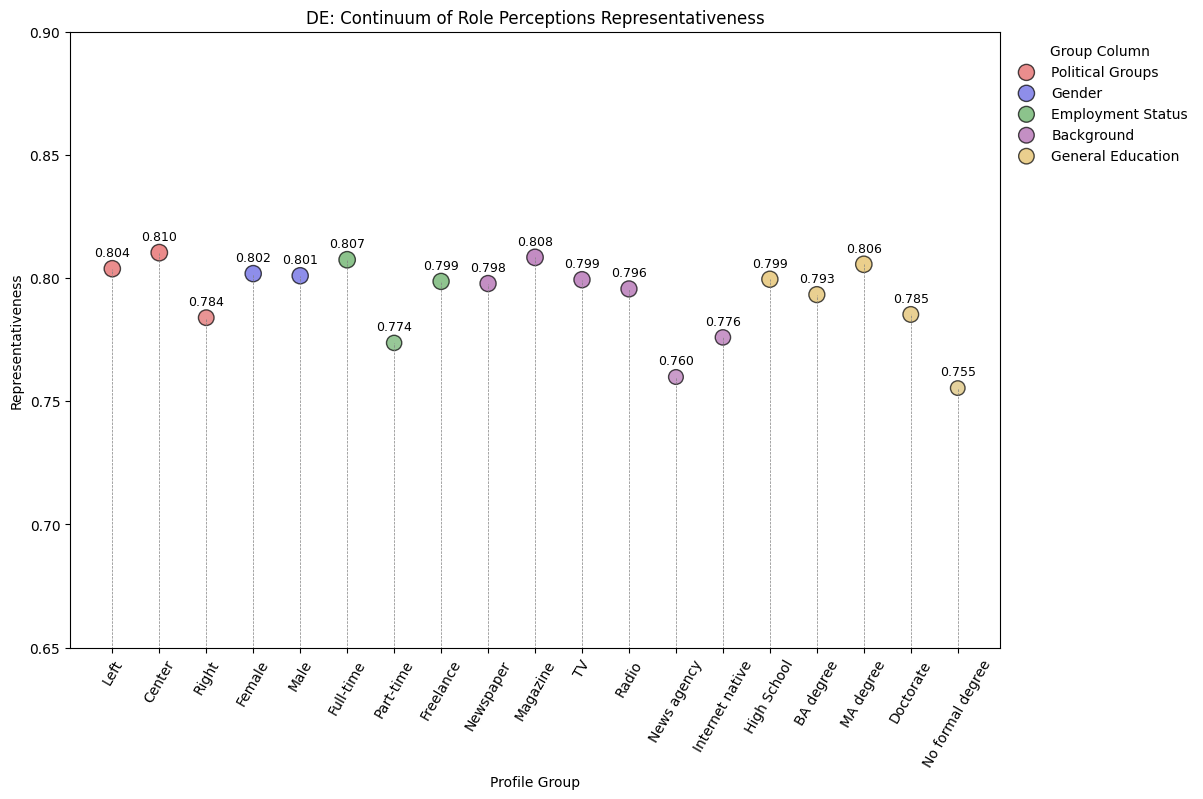

In [ ]:
#Total
variables = ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]
manual_title = "DE: Continuum of Role Perceptions Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

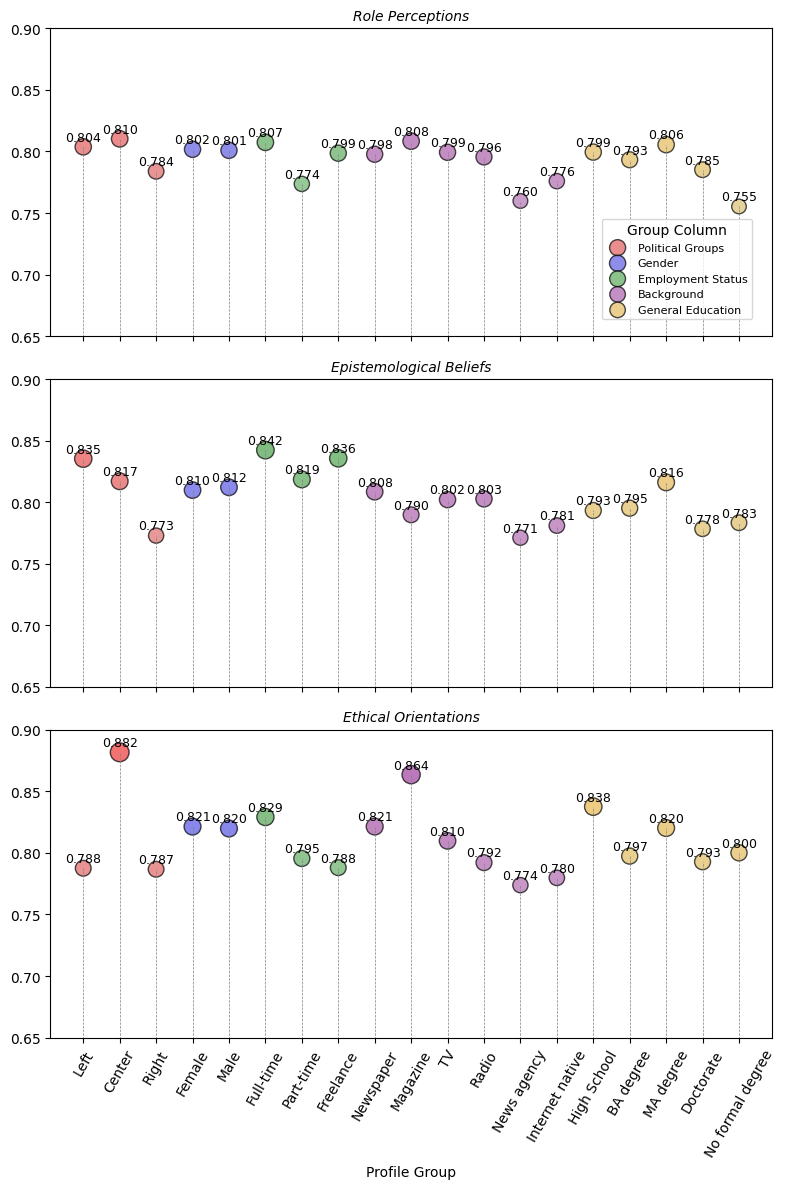

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Set up the figure with a vertical grid (3 rows, 1 column)
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Adjust figsize for letter-size format (8x12)

# Define variables and titles for each plot
plots_data = [
    {
        "variables": ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
                      "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
                      "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"],
        "manual_title": "Continuum of Role Perception Representativeness",
        "subtitle": "Role Perceptions"
    },
    {
        "variables": ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "epist2_A", "epist2_B", "epist2_C","epist2_D", "epist2_E", "epist2_F"],
        "manual_title": "Continuum of Epistemology Representativeness",
        "subtitle": "Epistemological Beliefs"
    },
    {
        "variables": ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"],
        "manual_title": "Continuum of Ethics Representativeness",
        "subtitle": "Ethical Orientations"
    }
]

# Function to create the plot
def generate_continuum_plot(ax, human_df, gpt_responses_df, variables, grouping_variables, plot_title, subtitle, is_first_subplot=False):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=1.0)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        # Plot the scatter
        scatter = ax.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=legend_labels.get(group_col, group_col),  # Use custom label here
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        ax.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        ax.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    ax.axhline(0.5, color='red', linestyle='--')
    ax.set_ylim(0.65, 0.90)
    ax.set_title(plot_title)  # Use the manually provided title
    ax.set_title(subtitle, fontsize=10, style='italic', loc='center')  # Subtitle for each plot

    # Set the x-axis label only for the last (bottom) subplot
    if ax == axs[2]:
        ax.set_xlabel('Profile Group')

    # Remove x-axis labels for all but the last subplot
    if ax != axs[2]:
        ax.set_xticklabels([])

    # Rotate x-ticks for readability
    ax.tick_params(axis='x', rotation=60)

    # Add legend to the first subplot only and make it smaller
    if is_first_subplot:
        ax.legend(title='Group Column', loc='upper right', fontsize=8, frameon=True, bbox_to_anchor=(0.98, 0.40))

# Loop through the plots_data and generate each plot in the corresponding subplot
for i, plot_data in enumerate(plots_data):
    variables = plot_data['variables']
    title = plot_data['manual_title']
    subtitle = plot_data['subtitle']
    is_first_subplot = (i == 0)  # Add legend only to the first subplot
    generate_continuum_plot(axs[i], human_df, gpt_responses_df, variables, GROUPING_VARIABLES, title, subtitle, is_first_subplot)

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the combined plot
plt.show()

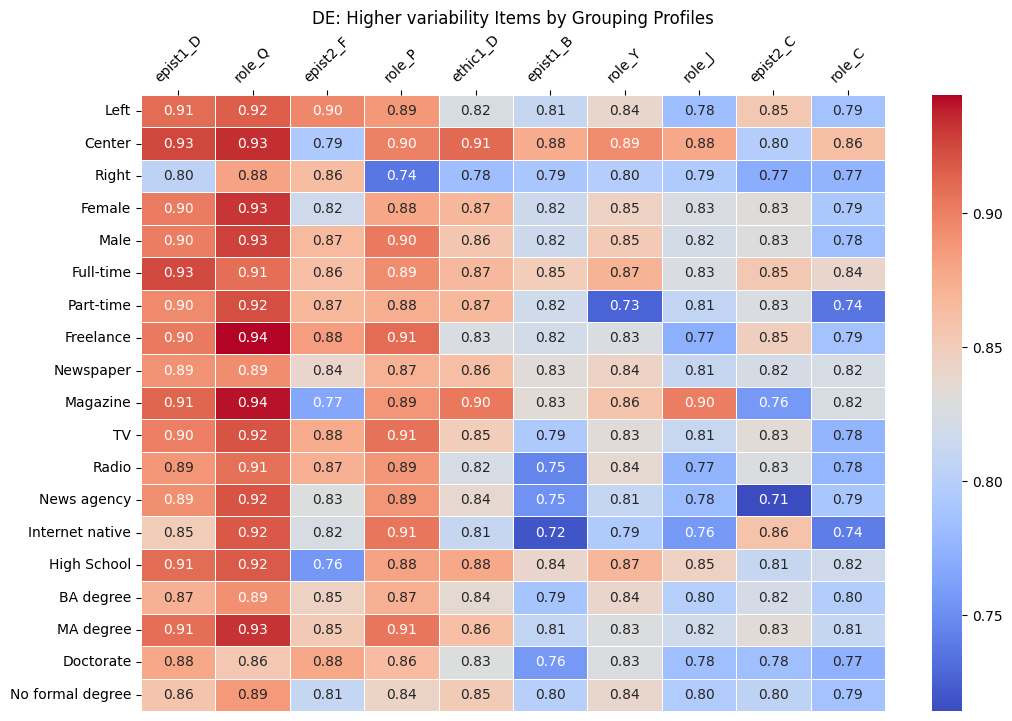

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        rows_list.append(group_distances)

    results_df = pd.DataFrame(rows_list, index=group_labels.values(), columns=variables)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the heatmap
def generate_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    all_heatmaps = []

    for group_col, group_labels in grouping_variables.items():
        heatmap_data = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_heatmaps.append(heatmap_data)

    # Combine heatmaps
    combined_heatmap_data = pd.concat(all_heatmaps)

    # Generate heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(combined_heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

    # Move the x-axis labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')  # Also move the x-axis label to the top

    plt.xticks(rotation=45)
    plt.title('DE: Higher variability Items by Grouping Profiles')
    plt.show()

# Example usage (previously defined)
variables = ["epist1_D", "role_Q", "epist2_F", "role_P", "ethic1_D",
             "epist1_B", "role_Y", "role_J", "epist2_C", "role_C"]

# Generate the heatmap
generate_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)